# Analyzing COVID-19 data in Mexico

In this notebook I will analyze a data set with COVID-19 data in Mexico using the CRISP-DM process. This data set is updated daily and can be found in the Mexico City government [webpage](https://datos.cdmx.gob.mx/explore/dataset/casos-asociados-a-covid-19/). I downloaded the data from this page on May 15th 2020, and I compressed it using 'gzip' method from pandas.

## Business and Data Understanding

Let's begin by taking a look a the data.

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import json
from scipy.integrate import odeint
from scipy.optimize import leastsq, minimize, least_squares
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Read the data
english_cols = ['date_update','origin','sector','medical_unit_entity','sex','birth_entity',
'residency_entity','municipality_of_residence','patient_type','admission_date',
'date_symptoms','death_date','intubed','pneumonia','age','nationality',
'pregnancy','speaks_indigenous_language','diabetes','copd','asthma',
'immunosuppression','hypertension','other_complication','cardiovascular',
'obesity','chronic_kidney','tobacco','another_case','outcome','migrant',
'country_nationality','country_of_origin','intensive_care_unit','age_range',
'register_id','death','hospitalized']
covid_data = pd.read_csv('covid-19-mex.csv', skiprows=1, names = english_cols, compression='gzip')

In [3]:
covid_data.head()

date_update          origin sector medical_unit_entity     sex  \
0  2020-05-15  FUERA DE USMER    SSA              MÉXICO   MUJER   
1  2020-05-15  FUERA DE USMER    SSA    CIUDAD DE MÉXICO   MUJER   
2  2020-05-15           USMER   IMSS           CHIHUAHUA  HOMBRE   
3  2020-05-15           USMER   IMSS     BAJA CALIFORNIA   MUJER   
4  2020-05-15  FUERA DE USMER    SSA    CIUDAD DE MÉXICO  HOMBRE   

       birth_entity  residency_entity municipality_of_residence  \
0            OAXACA            MÉXICO                       NaN   
1          GUERRERO  CIUDAD DE MÉXICO                   Tlalpan   
2         CHIHUAHUA         CHIHUAHUA                       NaN   
3           SINALOA   BAJA CALIFORNIA     Cuajimalpa de Morelos   
4  CIUDAD DE MÉXICO  CIUDAD DE MÉXICO            Álvaro Obregón   

    patient_type admission_date  ...     another_case              outcome  \
0  HOSPITALIZADO     2020-04-29  ...               SI  Positivo SARS-CoV-2   
1    AMBULATORIO     2020-05-08  ...               SI  Positivo SARS-CoV-2   
2  HOSPITALIZADO     2020-03-28  ...  NO ESPECIFICADO  Positivo SARS-CoV-2   
3  HOSPITALIZADO     2020-04-14  ...  NO ESPECIFICADO  Positivo SARS-CoV-2   
4    AMBULATORIO     2020-04-28  ...               NO  Positivo SARS-CoV-2   

           migrant country_nationality  country_of_origin intensive_care_unit  \
0  NO ESPECIFICADO             M√©xico                 99                  NO   
1  NO ESPECIFICADO             M√©xico                 99           NO APLICA   
2  NO ESPECIFICADO             M√©xico                 99                  NO   
3  NO ESPECIFICADO             M√©xico                 99                  NO   
4  NO ESPECIFICADO             M√©xico                 99           NO APLICA   

  age_range register_id death hospitalized  
0     61-70      09b8d9   1.0          1.0  
1     21-30      063fa6   NaN          NaN  
2     51-60      175605   1.0          1.0  
3     41-50      0f351c   NaN          1.0  
4     51-60      094730   NaN          NaN  

[5 rows x 38 columns]

In [4]:
covid_data.shape

(163691, 38)

In [5]:
covid_data.describe(include = 'all')

date_update          origin  sector medical_unit_entity     sex  \
count       163691          163691  163691              163691  163691   
unique           1               2      13                  32       2   
top     2020-05-15  FUERA DE USMER     SSA    CIUDAD DE MÉXICO  HOMBRE   
freq        163691          104186   95816               44232   83615   
mean           NaN             NaN     NaN                 NaN     NaN   
std            NaN             NaN     NaN                 NaN     NaN   
min            NaN             NaN     NaN                 NaN     NaN   
25%            NaN             NaN     NaN                 NaN     NaN   
50%            NaN             NaN     NaN                 NaN     NaN   
75%            NaN             NaN     NaN                 NaN     NaN   
max            NaN             NaN     NaN                 NaN     NaN   

            birth_entity  residency_entity municipality_of_residence  \
count             163691            163691                     71932   
unique                33                32                        16   
top     CIUDAD DE MÉXICO  CIUDAD DE MÉXICO                Iztapalapa   
freq               39899             37399                      9012   
mean                 NaN               NaN                       NaN   
std                  NaN               NaN                       NaN   
min                  NaN               NaN                       NaN   
25%                  NaN               NaN                       NaN   
50%                  NaN               NaN                       NaN   
75%                  NaN               NaN                       NaN   
max                  NaN               NaN                       NaN   

       patient_type admission_date  ... another_case                 outcome  \
count        163691         163691  ...       163691                  163691   
unique            2            136  ...            3                       3   
top     AMBULATORIO     2020-05-11  ...           SI  No positivo SARS-CoV-2   
freq         122149           6684  ...        56023                   89631   
mean            NaN            NaN  ...          NaN                     NaN   
std             NaN            NaN  ...          NaN                     NaN   
min             NaN            NaN  ...          NaN                     NaN   
25%             NaN            NaN  ...          NaN                     NaN   
50%             NaN            NaN  ...          NaN                     NaN   
75%             NaN            NaN  ...          NaN                     NaN   
max             NaN            NaN  ...          NaN                     NaN   

                migrant country_nationality  country_of_origin  \
count            163691              163691             163691   
unique                3                  76                 37   
top     NO ESPECIFICADO             M√©xico                 99   
freq             162968              162209             163417   
mean                NaN                 NaN                NaN   
std                 NaN                 NaN                NaN   
min                 NaN                 NaN                NaN   
25%                 NaN                 NaN                NaN   
50%                 NaN                 NaN                NaN   
75%                 NaN                 NaN                NaN   
max                 NaN                 NaN                NaN   

       intensive_care_unit age_range register_id   death hospitalized  
count               163691    163665      163691  7100.0      41542.0  
unique                   4        11      163691     NaN          NaN  
top              NO APLICA     31-40      031038     NaN          NaN  
freq                122149     39565           1     NaN          NaN  
mean                   NaN       NaN         NaN     1.0          1.0  
std                    NaN       NaN         NaN     0.0          0

In [6]:
#explore values of data
print('columns unique values')
for col in covid_data.columns:
    print(col, covid_data[col].unique())

columns unique values
date_update ['2020-05-15']
origin ['FUERA DE USMER' 'USMER']
sector ['SSA' 'IMSS' 'SEMAR' 'PEMEX' 'ISSSTE' 'PRIVADA' 'NO ESPECIFICADO'
 'MUNICIPAL' 'ESTATAL' 'SEDEMA' 'UNIVERSITARIO' 'DIF' 'CRUZ ROJA']
medical_unit_entity ['MÉXICO' 'CIUDAD DE MÉXICO' 'CHIHUAHUA' 'BAJA CALIFORNIA' 'OAXACA'
 'SINALOA' 'TABASCO' 'AGUASCALIENTES' 'NUEVO LEÓN' 'TLAXCALA' 'YUCATÁN'
 'HIDALGO' 'DURANGO' 'CAMPECHE' 'SAN LUIS POTOSÍ' 'ZACATECAS' 'MORELOS'
 'TAMAULIPAS' 'GUANAJUATO' 'COAHUILA DE ZARAGOZA' 'MICHOACÁN DE OCAMPO'
 'VERACRUZ DE IGNACIO DE LA LLAVE' 'GUERRERO' 'BAJA CALIFORNIA SUR'
 'QUINTANA ROO' 'JALISCO' 'PUEBLA' 'SONORA' 'CHIAPAS' 'NAYARIT'
 'QUERÉTARO' 'COLIMA']
sex ['MUJER' 'HOMBRE']
birth_entity ['OAXACA' 'GUERRERO' 'CHIHUAHUA' 'SINALOA' 'CIUDAD DE MÉXICO' 'MÉXICO'
 'TABASCO' 'BAJA CALIFORNIA' 'AGUASCALIENTES' 'NUEVO LEÓN'
 'VERACRUZ DE IGNACIO DE LA LLAVE' 'TLAXCALA' 'YUCATÁN' 'HIDALGO'
 'DURANGO' 'CAMPECHE' 'SAN LUIS POTOSÍ' 'ZACATECAS' 'MORELOS'
 'MICHOACÁN DE OCAMPO' 

register_id ['09b8d9' '063fa6' '175605' ... '1e3f64' '1caf8e' '07db72']
death [ 1. nan]
hospitalized [ 1. nan]


From the above, we can see that this data contains medical information from all the people that have been tested for COVID-19 in Mexico. The column `outcome` tells us whether the COVID-19 test was positive, negative or is in process. The majority of the columns in this data set are categorical. There is only three numerical columns: age, death and hospitalized. Some columns and rows contain NAN values. However, other columns contain NAN values expressed in strings like 'NO APLICA', 'NO ESPECIFICADO', and 'SE IGNORA', that in english  mean 'NOT APPLY', 'NOT SPECIFIED', and 'IT IS IGNORED'.

It is clear that we will have to do some cleaning, but first let's formulate some interesting questions that could be answered with the data.

### Business Questions

I would like to understand the following questions with this data:

* 1. __What kind of people are infected with COVID-19 in Mexico?__ To answer this question we will have to look at columns such as sex, age or municipality_residence.
* 2. __What is related to the severity of COVID 19? Specifically, can we predict whether a person is likely to be intubated, hospitalized, or whether a person will survive the disease?__  To answer this question we will have to look at columns such as intubated, diabetes, asthma etc.
* 3. __Can we make a prediction for the end of the pandemic in Mexico City from this data?__ To answer this question we will use the data from daily cases in Mexico City and an epidemic model.

### First question

To prepare the data to answer the first question, let's replace the string encoded missing values with NAN values.

In [7]:
#Replace strings encoded NANs
nan_values = {'NO ESPECIFICADO': np.nan, 'SE IGNORA': np.nan, 'NO APLICA': np.nan}
covid_data.replace(nan_values, inplace=True)  

Now let's see what kind of people are infected with COVID-19 in Mexico in terms of sex, age, and geographical location.

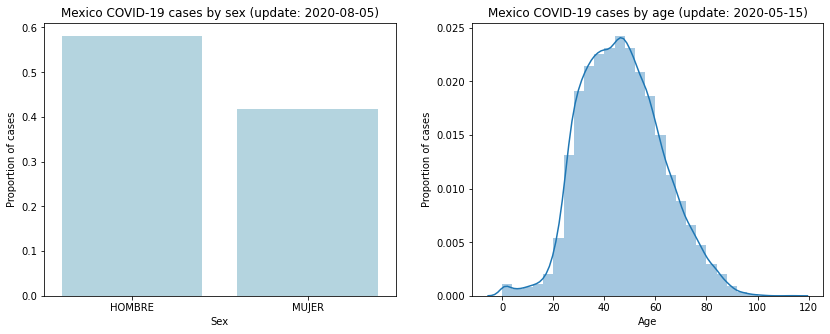

In [8]:
# Filter confirmed cases
confirmed_cases = covid_data[covid_data['outcome'] == 'Positivo SARS-CoV-2']

# Make plot of confirmed cases by sex
cases_by_sex = (confirmed_cases.sex.value_counts() / confirmed_cases.shape[0]).reset_index()
base_color = sns.color_palette()[0]

fig, axs = plt.subplots(1,2, figsize= (12,5))
axs = axs.flatten()
plt.sca(axs[0])
sns.barplot(data=cases_by_sex, x='index', y= 'sex', color='lightblue');
plt.title('Mexico COVID-19 cases by sex (update: 2020-08-05)')
plt.ylabel('Proportion of cases')
plt.xlabel('Sex')


# Make plot of confirmed cases by age
plt.sca(axs[1])
bin_edges = np.arange(0, 100 + 4, 4)
sns.distplot(confirmed_cases['age'], bins=bin_edges, color=base_color)
plt.title('Mexico COVID-19 cases by age (update: 2020-05-15)')
plt.ylabel('Proportion of cases')
plt.xlabel('Age')
fig.tight_layout(pad=2);

From the above we can see that the majority of people infected with COVID-19 in Mexico are males, and that the age of the infected people follows a normal distribution with a mode between 40 and 60 years. Now let's make some maps to see the geographical distribution of the data.

In [9]:
#Function to unify state names from map and COVID data
def unify_estate_names(string):
    '''unifies the states names of mexican states and COVID data
    INPUT string(str) : name of the state
    OUTPUT: name of the state in correct format
    '''
    #convert estate names to lower
    string = string.lower()
    #delete accents
    replace_dict = {'á':'a', 'é':'e','í':'i','ó':'o','ú':'u'}
    for char, replace_char in replace_dict.items():
        string = string.replace(char, replace_char)
    #correct states with other names
    string = string.replace('michoacan de ocampo', 'michoacan')
    string = string.replace('veracruz de ignacio de la llave', 'veracruz')
    string = string.replace('coahuila de zaragoza', 'coahuila')
    return string
 
#Read mexican states geojson
mexican_states = gpd.read_file('mexican_states.geojson')   
#count total cases per state
cases_per_satate = confirmed_cases.groupby('residency_entity').count()['outcome'].reset_index(name = 'count').copy()
# Unify states names between map and data to be able to merge
mexican_states.admin_name = \
    mexican_states.admin_name.replace({'Distrito Federal': 'ciudad de mexico'}).str.lower()
cases_per_satate.residency_entity = cases_per_satate.residency_entity.apply(lambda x:  unify_estate_names(x)) 
#Merge map and total cases per state
cases_per_satate = mexican_states[['admin_name', 'geometry']].merge(cases_per_satate,
                                                 how = 'inner', 
                                                 right_on = 'residency_entity',
                                                left_on = 'admin_name')
#Convert to json
merged_json = json.loads(cases_per_satate.to_json())
#Make the the state name the id of each feature
i=1
for feature in merged_json["features"]:
    feature['id'] = feature['properties']['admin_name']
    i += 1
#Plot choropleth    
fig = px.choropleth_mapbox(cases_per_satate, geojson=merged_json, locations='admin_name',
                           color='count',
                           color_continuous_scale="Viridis",
                           range_color=(cases_per_satate['count'].min(), cases_per_satate['count'].max()),
                           mapbox_style="carto-positron",
                           zoom=3.3,
                           center = {"lat": 24.0902, "lon": -100.7129},
                           opacity=0.5,
                           labels={'count':'Total cases', 
                                  'admin_name': 'State'},
                          )
fig.update_layout(title_text='COVID-19 cases by state in Mexico (update: 2020-05-15)',
                  title_x=0.5
                 )
fig.show()

In [10]:
#Read Mexico City municipalities data
mexico_city = gpd.read_file('mexico_city_municipalities.json')
#Filter CVOVID cases in Mexico city
mexico_city_cases = confirmed_cases[confirmed_cases['residency_entity'] == 'CIUDAD DE MÉXICO']
#Count total cases by municipality
mexico_city_cases_by_municipality = \
    mexico_city_cases.groupby('municipality_of_residence')['outcome'].count().reset_index(name = 'count')
#Merge map and total cases data
mexico_city_cases_by_municipality = mexico_city[['nom_mun','geometry']].merge(mexico_city_cases_by_municipality, 
                                       how = 'inner',
                                       left_on ='nom_mun',
                                       right_on = 'municipality_of_residence')
#Convert to json
merged_json = json.loads(mexico_city_cases_by_municipality.to_json())
#Make the the municipality name the id of each feature
i=1
for feature in merged_json["features"]:
    feature['id'] = feature['properties']['nom_mun']
    i += 1
#Plot choropleth      
fig = px.choropleth_mapbox(mexico_city_cases_by_municipality, geojson=merged_json, locations='nom_mun',
                           color='count',
                           color_continuous_scale="Viridis",
                           range_color=(mexico_city_cases_by_municipality['count'].min()
                                        , mexico_city_cases_by_municipality['count'].max()),
                           mapbox_style="carto-positron",
                           zoom=8.7,
                           center = {"lat": 19.3, "lon": -99.1},
                           opacity=0.5,
                           labels={'count':'Total cases',
                                  'nom_mun':'Municipality'}
                          )
fig.update_layout(title_text='COVID-19 cases by state in Mexico City (update: 2020-05-15)',
                  title_x=0.5
                 )
fig.show()

These maps show that the majority of cases are located in the center of Mexico, specially in Mexico City. Inside Mexico City, most of the cases are located in the municipalities Iztapalapa and Gustavo A. Madero, at the east and north of the city.

With this information we can answer our first question: __What kind of people are infected with COVID-19 in Mexico?__ The majority of people infected with COVID-19 are males of 40 to 60 years of age, on the center of the country.

### Second question 

In order to answer the second question we will construct a supervised machine learning model, but he have to do some cleaning first. Let's see the proportion of nan values in each column:

In [11]:
confirmed_cases.isna().sum() / confirmed_cases.shape[0]

date_update                   0.000000
origin                        0.000000
sector                        0.004930
medical_unit_entity           0.000000
sex                           0.000000
birth_entity                  0.006240
residency_entity              0.000000
municipality_of_residence     0.461250
patient_type                  0.000000
admission_date                0.000000
date_symptoms                 0.000000
death_date                    0.894142
intubed                       0.606546
pneumonia                     0.000067
age                           0.000000
nationality                   0.000000
pregnancy                     0.583963
speaks_indigenous_language    0.024094
diabetes                      0.007506
copd                          0.007461
asthma                        0.007728
immunosuppression             0.007661
hypertension                  0.007506
other_complication            0.009260
cardiovascular                0.007683
obesity                  

We will have to deal with these nans. In some columns it is fine to fill the nans with 0. For example, the column `death` is 1 when a person has died and is nan otherwise. In this case it would be ok to fill the nans with 0 to indicate that a person has not died.

In some other columns like `diabetes` or `copd`, I will assume that a nan value con be replaced with 'NO'. In other words, if we do not know whether a person has diabetes we will assume that he or she does not have the disease. This a a big assumption, but it will allows to answer the seconf question.

The are some columns that are uninformative and that we can drop from the dataset. For example, the column migrant had 99% of nan values, so we can drop it without problem. Also, the column `outcome` has the same value for all rows, so we can drop it from the dataset. In addition, if we want to predict the column `hospitalized` we will have to remove the column `intensive_care_unit` from the dataset because if someone is in intensive we can infer that this person is hospitalized, and the prediction would be too easy.

Finally, I will re-encode some binary categorical variables as binary numerical variables. In this way, we will only perform one hot encoding in multivariate categorical variables.

To sum up, the cleaning process will consist of 5 steps:

* 1. Replace nan values with zero in some columns
* 2. Replace nan values with NO in some columns
* 3. Remove uninformative columns
* 4. Re-encode binary categorical variables as binary numerical variables
* 5. Perform one hot encoding

The following function performs all these steps.

In [12]:
def clean_data (df, drop_cols, replace_with_no, replace_with_zero):
    '''Cleans the data of confirmed COVID cases
    INPUT:
        df (dataframe) . dataframe of confirmed COVID cases
        drop_cols (list)- columns to drop
        replace_with_no (list) - replace nan values with 'NO' in this columns
        replace_with_zero (list) - replace nan values with 0 in this columns
    OUTPUT:
        dataframe with cleaned data
        '''
    #make copy of confirmed cases data
    df_copy = df.copy()
    #replace nan values with no in these columns
    df_copy[replace_with_no] = \
        df_copy[replace_with_no].replace(np.nan, 'NO')
    #Replace nan values with zero in these columns
    df_copy[replace_with_zero] = \
        df_copy[replace_with_zero].replace(np.nan, 0)
    # Reencode binary categorical variables to numeric categoricals
    for col in df_copy.columns:
        if len (df_copy[col].unique()) == 2 and df_copy[col].dtype == 'O':
            first_val = np.sort(df_copy[col].unique())[0]
            df_copy[col] = df_copy[col].apply(lambda val: 0 if val == first_val else 1) 
    # drop uninformative cases columns
    df_copy.drop(columns = drop_cols, inplace= True)
    #Perform one hot encosing in multicategorical data
    df_copy = pd.get_dummies(df_copy, dummy_na=True)
    return df_copy

Now that we have a function to clean the data, we need a function to predict a column. I will use a Random Forest Classifier to try to predict the columns `hospitalized`, `intubed` and `death`. The following function performs a grid search to find the best model to predict these columns. I decided to optimize for precision score because I think that is worst to predict that a person will not develop a severe case of COVID-19 and be wrong, rather than to predict that a person will develop a sever case and be wrong.

In [13]:
def predict_column(df, predict_column, test_size, random_state):
    '''Predicts a column of cleaned COVID-19 making a randomized search in
    a random forest classifier
    INPUT:
        df (dataframe) - cleaned data dataframe
        predict_column (str) - column to be predicted
        test_size (float): propotion of the data used for test
        random_state (int): number to make reproducible results'''
    #split data into colun to predict and other columns
    X = df.drop(predict_column, axis=1)
    y = df[predict_column]
    #scale the data
    scaler = StandardScaler()
    X_scaled =scaler.fit_transform(X)
    #split data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)
    # Make random search
    model = RandomForestClassifier()
    param_dist = {"max_depth": [3, None],
                  "n_estimators": list(range(10, 200)),
                  "max_features": list(range(1, X_test.shape[1]+1)),
                  "min_samples_split": list(range(2, 11)),
                  "min_samples_leaf": list(range(1, 11)),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=5, scoring='precision')
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    # Score model
    test_preds = best_model.predict(X_test)
    train_preds = best_model.predict(X_train)
    train_precison = round(precision_score(y_train, train_preds), 2)
    test_presicion = round(precision_score(y_test, test_preds), 2)
    test_recall = round(recall_score(y_test, test_preds), 2)
    train_recall = round(recall_score(y_train, train_preds), 2)
    test_accuracy = round(accuracy_score(y_test, test_preds), 2)
    train_accuracy = round(accuracy_score(y_train, train_preds), 2)
    print('Train - presicion: {}, recall: {}, accuracy: {}'.format(
        train_precison, train_recall, train_accuracy))
    print('Test - presicion: {}, recall: {}, accuracy: {}'.format(
        test_presicion, test_recall, test_accuracy))
    # Get highest five feature importances
    highest_feature_importances = sorted(zip(X.columns, best_model.feature_importances_),
                                         key = lambda x: x[1],
                                         reverse = True)[:5]
    print('10 highest feature importances: ', highest_feature_importances)
    return best_model, test_presicion, test_recall, highest_feature_importances

Now let's try to predict the column `hospitalized`.

In [14]:
replace_with_no =['intubed','pregnancy', 'speaks_indigenous_language',
'diabetes','copd', 'asthma','immunosuppression','hypertension',
'other_complication','cardiovascular',  'obesity','chronic_kidney','tobacco',
'another_case', 'intensive_care_unit', 'pneumonia']
replace_with_zero = ['hospitalized', 'death']
drop_cols = ['date_update', 'birth_entity', 'death_date','migrant',
'country_nationality','country_of_origin', 'admission_date',
'date_symptoms', 'outcome', 'intensive_care_unit', 'medical_unit_entity',
'patient_type', 'death', 'register_id', 'age_range', 'intubed']

cleaned_covid_cases = clean_data(confirmed_cases, drop_cols, replace_with_no, replace_with_zero)
hospitalized_model, hospitalized_presicion, hospitalized_recall, hospitalized_importances = \
    predict_column(cleaned_covid_cases,'hospitalized', 0.3, 42)

Train - presicion: 0.88, recall: 0.68, accuracy: 0.84
Test - presicion: 0.87, recall: 0.68, accuracy: 0.84
10 highest feature importances:  [('pneumonia', 0.6708938529341743), ('age', 0.13552836137514637), ('another_case', 0.06045475119421509), ('origin', 0.04896862673875893), ('diabetes', 0.03500525657083554)]


I decided to  drop all the columns in the list `drop_cols` either because I found them uninformative (like `date_update` ot `birth_entity`), because their information was contained in other columns (like `age_range` or `death_date`), or because including them would imply cheating in the prediction (like `medical_unit_entity`).

We can see that the model performs well, with a test precision of 0.87, a recall of 0.68 and an accuracy of 0.84. The highest feature importance is `pneumonia`. This makes sense, since pneumonia is a severe condition and it requires hospitalization.  Age is also important when predicting if COVID-19 will require hospitalization.

Now let's predict the column `intubed`.

In [15]:
#Remove intubed from droped cols
drop_cols = ['date_update', 'birth_entity', 'death_date','migrant',
'country_nationality','country_of_origin', 'admission_date',
'date_symptoms', 'outcome', 'register_id', 'age_range']

cleaned_covid_cases = clean_data(confirmed_cases, drop_cols, replace_with_no, replace_with_zero)
intubed_model, intubed_presicion, intubed_recall, intubed_importances = \
    predict_column(cleaned_covid_cases,'intubed', 0.3, 42)

Train - presicion: 0.82, recall: 0.36, accuracy: 0.97
Test - presicion: 0.79, recall: 0.35, accuracy: 0.97
10 highest feature importances:  [('intensive_care_unit', 0.6735232194920842), ('death', 0.12922058148855686), ('sector_IMSS', 0.05656015520774858), ('hospitalized', 0.046845495510249316), ('pneumonia', 0.04240918954989293)]


The resulting model has a  test precision of 0.79, a recall of 0.35 and an accuracy of 0.97. This means that there are many false negatives in the predictions. In other words, there are a lot of cases that the model incorrectly predicts as non intubated. The most important features for predicting this column are intensive_care_unit and pneumonia.

Noe let's predict the column `death`.

In [22]:
drop_cols = ['date_update', 'birth_entity', 'death_date','migrant',
'country_nationality','country_of_origin', 'admission_date',
'date_symptoms', 'outcome','patient_type', 'register_id', 'age_range']
cleaned_covid_cases = clean_data(confirmed_cases, drop_cols, replace_with_no, replace_with_zero)
death_model, death_presicion, death_recall, death_importances = predict_column(cleaned_covid_cases,'death', 0.3, 42)

Train - presicion: 0.81, recall: 0.03, accuracy: 0.9
Test - presicion: 0.74, recall: 0.03, accuracy: 0.9
10 highest feature importances:  [('hospitalized', 0.2813556020750267), ('pneumonia', 0.24862874347821698), ('intubed', 0.20395943309737105), ('age', 0.0862143414409627), ('intensive_care_unit', 0.08083094459647597)]


The resulting model has a test precision of 0.74, a recall of 0.03 and an accuracy of 0.9. The recall is very low, so there are many false positives in the predictions. The most important features for predicting this column are `intubed`, `hospitalized`, `pneumonia` and `age`.

Finally, in the predictions of all the above columns, `pneomonia` was an important column, so let's see what is related to pneumonia.

In [17]:
drop_cols = ['date_update', 'birth_entity', 'death_date','migrant',
'country_nationality','country_of_origin', 'admission_date',
'date_symptoms', 'outcome','patient_type', 'register_id', 'age_range', 'hospitalized',
            'death', 'intensive_care_unit', 'intubed']
cleaned_covid_cases = clean_data(confirmed_cases, drop_cols, replace_with_no, replace_with_zero)
pneumonia_model, pneumonia_presicion, pneumonia_recall, pneumonia_importances = \
    predict_column(cleaned_covid_cases,'pneumonia', 0.3, 42)

Train - presicion: 0.75, recall: 0.11, accuracy: 0.73
Test - presicion: 0.73, recall: 0.11, accuracy: 0.72
10 highest feature importances:  [('age', 0.3361215589241379), ('origin', 0.22756077771415936), ('diabetes', 0.1699041157875424), ('another_case', 0.07948983857052859), ('hypertension', 0.06388904432715216)]


The model for predicting pneumonia has a test precision of 0.73, a recall of 0.11 and an accuracy of 0.71. Again, the low recall indicates many false positives. The most important features for predicting this column are `age`, `origin` and `diabetes`.

With this information we are now able to answer our second question: **What is related to the severity of COVID 19? Specifically, can we predict whether a person is likely to be intubated, hospitalized, or whether a person will survive the disease?** 

We we able to make models to predict whether a case of COVID-19 will be severe, requiring intubation, hospitalization, or leading to death with a precision higher than 70%. However, these models produce many false positives. Hospitalization is related to pneumonia and age. Intubation is related to intensive_care_unit and pneumonia. Death is related to hospitalized, pneumonia and age. In all these columns pneumonia is an important factor for the prediction. Age is also and important factor. As a result we can conclude that the severity of COVID-19 is related to age and developing pneumonia. In turn, pneumonia is related to age, origin and diabetes.

Let's make a visualization of these results

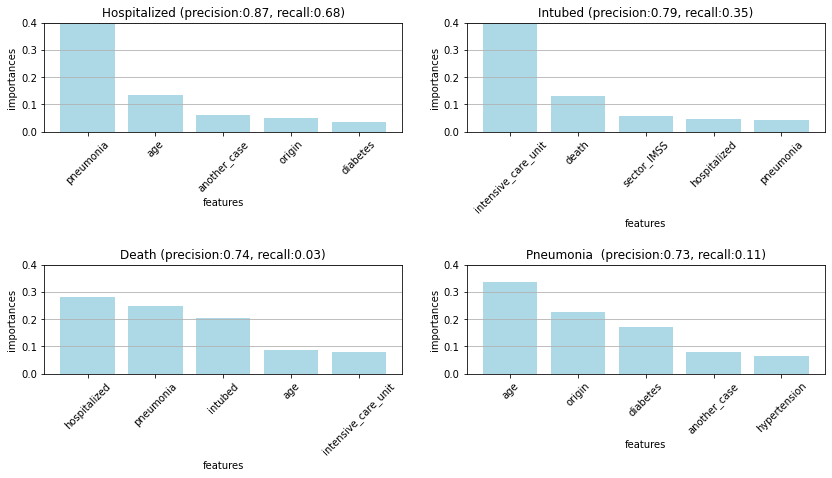

In [23]:
feats = [hospitalized_importances, intubed_importances, death_importances, pneumonia_importances]
scores = [[hospitalized_presicion, hospitalized_recall], [intubed_presicion, intubed_recall],
         [death_presicion, death_recall], [pneumonia_presicion, pneumonia_recall]]
titles = ['Hospitalized' , 'Intubed', 'Death', 'Pneumonia ']
fig, axs = plt.subplots(2,2, figsize = (12,7))
axs = axs.flatten()
for i in range(len(axs)):
    plt.sca(axs[i])
    feat, imp = zip(*feats[i])
    plt.bar(feat, imp, color = 'lightblue')
    plt.xlabel('features')
    plt.ylabel('importances')
    plt.xticks(rotation = 45)
    plt.title(titles[i] + f' (precision:{scores[i][0]}, recall:{scores[i][1]})')
    plt.ylim([0, 0.4])
    axs[i].yaxis.grid(True) 
fig.tight_layout(pad=2)


### Third question

To answer the third question we will use a simple [SIR model](https://mathworld.wolfram.com/SIRModel.html). This model consists of three ordinary differential equations:

\begin{equation}
\frac{dS}{dt} = \frac{-\beta S I}{N}
\end{equation}

\begin{equation}
\frac{dI}{dt} = \frac{\beta S I}{N} -\gamma I
\end{equation}

\begin{equation}
\frac{dR}{dt} = \gamma I
\end{equation}

where  $t$ is time, $S(t)$ is the number of susceptible people, $I(t)$ is the number of people infected, $R(t)$ is the number of people who have recovered and developed immunity to the infection, $\beta$ is the infection rate, $\gamma$ is the recovery rate, and $N$ is the size of the population.

We will try to fit this system of differential equations to the data of daily cases of COVID-19 in Mexico City to try to predict when the pandemic will end. The first thing we need to do is prepare our data to have a dataset of cases by day in Mexico City. 

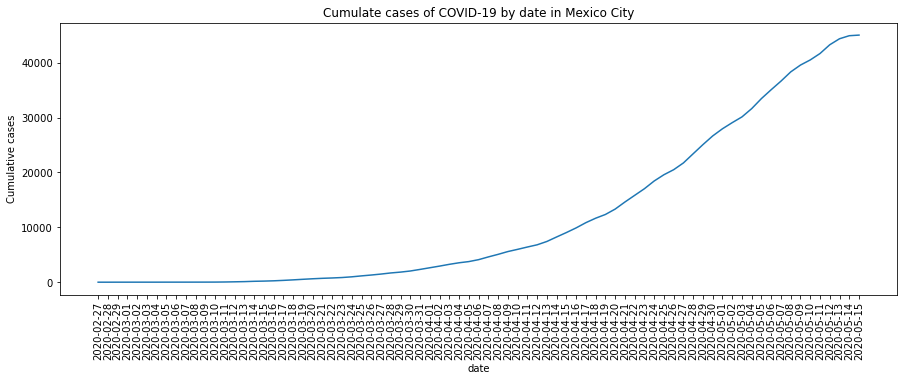

In [19]:
#select relevant columns from data
cases_by_date = covid_data[['date_update','admission_date', 'residency_entity', 'outcome']].copy()
#Translate values of outcome column
cases_by_date.outcome= cases_by_date.outcome.replace(
    {'Positivo SARS-CoV-2':'infected',
    'No positivo SARS-CoV-2':'not infected',
    'Resultado pendiente': 'suceptible'})
#pivot table by outcome and count total cases by day
cases_by_date = pd.pivot_table(cases_by_date, index=['admission_date', 'residency_entity'],
               aggfunc='count', columns='outcome', values='date_update').reset_index().fillna(0)
#make cumulative sum of cases by day
cases_by_date[['infected_cumsum','not infected_cumsum','suceptible_cumsum']] = \
    cases_by_date[['infected','not infected','suceptible']].cumsum()
#Remove rows without sporadic cases before 27th february
cases_by_date = cases_by_date[cases_by_date['admission_date'] >= '2020-02-27']
#filter for Mexco City and sort by date
cases_mexico_city = cases_by_date[cases_by_date['residency_entity']=='CIUDAD DE MÉXICO'].sort_values(by='admission_date')

#Plot cumulative cases
plt.figure(figsize=(15,5))
plt.plot(cases_mexico_city['admission_date'], cases_mexico_city['infected_cumsum'])
plt.xlabel('date')
plt.ylabel('Cumulative cases')
plt.title('Cumulate cases of COVID-19 by date in Mexico City')
plt.xticks(rotation=90);

Now that we have our dataset ready, we need some code to fit the SIR model to the data. The following class does just that.

In [20]:
class SIR():
    '''class to fit and predict epidemiological data with SIR model'''
    def __init__(self, cond_ini):
        '''Initualize attributes
        
        cond_ini- [S0, I0, R0] list with initial conditions for:
            S: number of sucueptible persons
            I: number of infected persons
            R: number of recovered persons
        params- tuple (beta, gamma): tuple with parameters beta and gamma
        '''
        self.cond_ini = cond_ini
        self.params = (0.001, 0.001)

    def SIR_ode(self, x0, t, params):
        '''Calculates system of ODES defining SIR model       
        '''      
        S = x0[0]
        I = x0[1]
        R = x0[2]
        N = S0 + I0 + R0
        
        beta = params[0]
        gamma = params[1]
        
        dSdt = - (beta * I * S) / N 
        dIdt = (beta * I * S / N) - gamma * I
        dRdt = gamma * I
        
        return [dSdt, dIdt, dRdt]    
    
    def integate_SIR(self, t, params):
        '''Integates SIR model'''
        SIR = odeint(self.SIR_ode, y0=self.cond_ini,  t=t, args=(params,))
        S,I,R = zip(*SIR)
        return S,I,R
        
    def fit(self, I_data):
        '''Fits the SIR model on the data of infected persons by day
        using least squares optimization
        '''
        len_data = len(I_data)
        t = np.arange(1, len_data+1)
        
        def objective(params):
            S,I,R = self.integate_SIR(t, params)
            return np.cumsum(I_data) - np.cumsum(I)
            #return np.array(I_data) - I
        
        optim = least_squares(objective, (0.5, 0.5), bounds=(0.00001,1))
        beta, gamma = optim.x
        self.params = (beta, gamma)
        print(self.params)
        self.t = t
    
    def predict(self, t = None):
        '''predicts data using SIR model'''
        if not isinstance(t, (list,np.ndarray)):
            t = self.t
        return self.integate_SIR(t, self.params)

Now let's fit the model to our data. 

(0.3361718969104882, 0.2677855627600055)


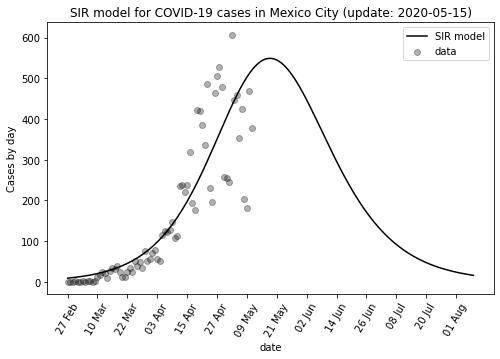

In [21]:
#initial conditions
S0 =  2 * cases_mexico_city['infected'][:-3].sum()
I0 = cases_mexico_city.iloc[0]['infected_cumsum']
R0 = 0
x0 = [S0, I0, R0]

#variables for prediction
infected_cases = cases_mexico_city['infected'][1:-3]
t = np.arange(1,infected_cases.shape[0] +1 ,1)

#initialize and fit model
model = SIR(x0)
model.fit(infected_cases)

#predict futher in time
tf = np.arange(1, 2*len(t) + 15 ,1)
preds_S, preds_I, preds_R = model.predict(t=tf)

#make xticks dates
sdate = date(2020,2, 27)   # start date
edate = sdate + timedelta(days=len(preds_S))  # end date
delta = edate - sdate       # as timedelta
days = [sdate + timedelta(days=i) for i in range(delta.days)]
days = [date.strftime("%d %b") for date in days]
xticks = [days[x] for x in np.arange(0,len(days) +1, 12)]

#plot results
plt.figure(figsize=(8,5))
plt.scatter(days[:len(t)], infected_cases, alpha = 0.3, color = 'k', label = 'data')
plt.plot(days, preds_I, color = 'k', label = 'SIR model')
plt.ylabel('Cases by day')
plt.xlabel('date')
plt.title('SIR model for COVID-19 cases in Mexico City (update: 2020-05-15)')
plt.xticks(xticks, rotation = 60)
plt.legend();

Now we can answer our third question: **Can we make a prediction for the end of the pandemic in Mexico City from this data?** The answer is yes, fitting a simple SIR model to the data we can predict that the pandemic will be over by August. However, we have to acknowledge that this model is very simple, and it probably can not capture the complexity of a real pandemic.